In [28]:
import Pkg

using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
using CSV
using Random
using DataFrames
using Optimisers
using Statistics
using Plots

using DecisionTree


In [29]:
sunspot_data = CSV.read("Sunspot_data.csv", DataFrame)

sunspots = sunspot_data[:, 3];

In [30]:
function create_sequences(data, seq_len)
    X, y = [], []
    for i in 1:(length(data) - seq_len)
        push!(X, data[i:i+seq_len-1])
        push!(y, data[i+seq_len])
    end
    return hcat(X...), y  # Convert to matrix form
end

seq_len = 50  # Lookback window
X, y = create_sequences(sunspots, seq_len)

# Normalize
X = (X .- mean(X)) ./ std(X)
y = (y .- mean(y)) ./ std(y)

train_ratio = 0.9


split_var = Int(train_ratio * size(X, 2))

X_train, y_train = X[:, 1:split_var], y[1:split_var]
X_test, y_test = X[:, split_var+1:end], y[split_var+1:end]

X_train = reshape(X_train, size(X_train, 1), 1, size(X_train, 2))
X_test = reshape(X_test, size(X_test, 1), 1, size(X_test, 2))

y_train = reshape(y_train, 1, length(y_train))  # Convert to (1, batch_size)
y_test = reshape(y_test, 1, length(y_test))    # Convert to (1, batch_size)
;

In [31]:
# Data should be stored in WHCN order (width, height, # channels, batch size). 
# In other words, a 100×100 RGB image would be a 100×100×3×1 array, and a batch of 50 would be a 100×100×3×50 array.

model = Chain(

    # Layer 1 -> takes 1 channel and returns out 16 channels followed by MaxPool and BatchNorm
    Conv((5,), 1=>16, relu),
    MaxPool((2,)),
    BatchNorm(16),


    # Layer 2 -> takes 16 channels and returns out 32 channels followed by MaxPool and BatchNorm
    Conv((3,), 16=>32, relu),
    MaxPool((2,)),
    BatchNorm(32),

    # Layer 3 -> Flattening
    Flux.flatten,

    # Layer 4 -> Dense Layer
    Dense(320, 64, relu),  

    # Layer 5 -> Output Layer
    Dense(64, 10, relu),

    # Layer 6 -> Output Layer that returns a single value corresponding to the predicted sunspot count
    Dense(10, 1),
     )   
     
# Note no softmax since we are not doing classification but regression and want to predict a single value

     

Chain(
  Conv((5,), 1 => 16, relu),            # 96 parameters
  MaxPool((2,)),
  BatchNorm(16),                        # 32 parameters, plus 32
  Conv((3,), 16 => 32, relu),           # 1_568 parameters
  MaxPool((2,)),
  BatchNorm(32),                        # 64 parameters, plus 64
  Flux.flatten,
  Dense(320 => 64, relu),               # 20_544 parameters
  Dense(64 => 10, relu),                # 650 parameters
  Dense(10 => 1),                       # 11 parameters
)         # Total: 14 trainable arrays, 22_965 parameters,
          # plus 4 non-trainable, 96 parameters, summarysize 91.184 KiB.

In [32]:
epochs = 200
batch_size = 64;

In [33]:
opt = ADAM()

data_loader = Flux.DataLoader((X_train, y_train), batchsize=batch_size, shuffle=true)

# Initialize optimizer state
opt_state = Flux.setup(opt, model)  

total_loss = []

for epoch in 1:epochs
    epoch_loss = 0
    for (x, y) in data_loader
        gs = Flux.gradient(model -> Flux.Losses.mse(model(x), y), model)[1]  
        Flux.update!(opt_state, Flux.trainable(model), gs)
        epoch_loss += Flux.Losses.mse(model(x), y)
    end
    println("Epoch $epoch - Train Loss: $epoch_loss")
    push!(total_loss, epoch_loss)
end


Epoch 1 - Train Loss: 20.418474408478005
Epoch 2 - Train Loss: 7.135874553225596
Epoch 3 - Train Loss: 5.870988010241856
Epoch 4 - Train Loss: 5.269997119432478
Epoch 5 - Train Loss: 4.947763418905523
Epoch 6 - Train Loss: 4.667105861199717
Epoch 7 - Train Loss: 4.377365114429782
Epoch 8 - Train Loss: 4.053446992231938
Epoch 9 - Train Loss: 3.686479471922184
Epoch 10 - Train Loss: 3.7429620860625286
Epoch 11 - Train Loss: 3.579336998964033
Epoch 12 - Train Loss: 3.2329516098654896
Epoch 13 - Train Loss: 3.152067650915971
Epoch 14 - Train Loss: 3.024712666391377
Epoch 15 - Train Loss: 2.913165124690732
Epoch 16 - Train Loss: 2.6370174814725282
Epoch 17 - Train Loss: 2.5540121946919006
Epoch 18 - Train Loss: 2.66893752269731
Epoch 19 - Train Loss: 2.3942432814757315
Epoch 20 - Train Loss: 2.4000779784786266
Epoch 21 - Train Loss: 2.259321808160528
Epoch 22 - Train Loss: 2.167607552110923
Epoch 23 - Train Loss: 1.9442138055155012
Epoch 24 - Train Loss: 1.8778906812942129
Epoch 25 - Train 

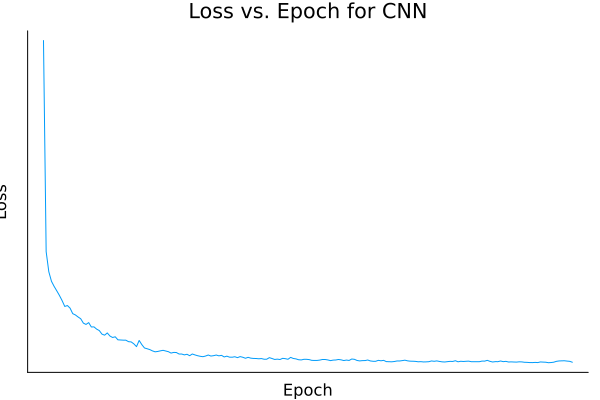

In [34]:
p1 = plot(1:epochs, total_loss, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch for CNN", legend=false, xticks=false, yticks=false)
display(p1)

In [35]:
# Basic DNN with approximately same number of parameters as the CNN

model_DNN = Chain(
    Dense(50, 64, relu),
    Dense(64, 128, relu),
    Dense(128, 64, relu),
    Dense(64, 32, relu),
    Dense(32, 1)
)


Chain(
  Dense(50 => 64, relu),                # 3_264 parameters
  Dense(64 => 128, relu),               # 8_320 parameters
  Dense(128 => 64, relu),               # 8_256 parameters
  Dense(64 => 32, relu),                # 2_080 parameters
  Dense(32 => 1),                       # 33 parameters
)                   # Total: 10 arrays, 21_953 parameters, 86.262 KiB.

In [37]:

opt_state_DNN = Flux.setup(opt, model_DNN)  

total_loss_2 = []

for epoch in 1:epochs
    epoch_loss = 0
    for (x, y) in data_loader
        gs = Flux.gradient(model_DNN -> Flux.Losses.mse(Flux.flatten(model_DNN(x)), y), model_DNN)[1]  
        Flux.update!(opt_state_DNN, Flux.trainable(model_DNN), gs)
        epoch_loss += Flux.Losses.mse(Flux.flatten(model_DNN(x)), y)
    end
    println("Epoch $epoch - Train Loss: $epoch_loss")
    push!(total_loss_2, epoch_loss)
end


Epoch 1 - Train Loss: 7.856290331225126
Epoch 2 - Train Loss: 5.149450394708337
Epoch 3 - Train Loss: 4.657379302918369
Epoch 4 - Train Loss: 4.455309867378185
Epoch 5 - Train Loss: 4.2209279242023685
Epoch 6 - Train Loss: 3.8710761190162573
Epoch 7 - Train Loss: 3.730782115103892
Epoch 8 - Train Loss: 3.688774533170429
Epoch 9 - Train Loss: 3.4643012256156895
Epoch 10 - Train Loss: 3.3457494438696425
Epoch 11 - Train Loss: 3.128479506658027
Epoch 12 - Train Loss: 3.1120492753397992
Epoch 13 - Train Loss: 3.006736017752199
Epoch 14 - Train Loss: 3.012647300122717
Epoch 15 - Train Loss: 2.6835988057081726
Epoch 16 - Train Loss: 2.5074266463022195
Epoch 17 - Train Loss: 2.457857210576614
Epoch 18 - Train Loss: 2.6663744141323678
Epoch 19 - Train Loss: 2.3502257228870267
Epoch 20 - Train Loss: 2.192242210355004
Epoch 21 - Train Loss: 2.120814924350214
Epoch 22 - Train Loss: 1.940489221842445
Epoch 23 - Train Loss: 1.9320465191544076
Epoch 24 - Train Loss: 1.8333947509364341
Epoch 25 - Tra

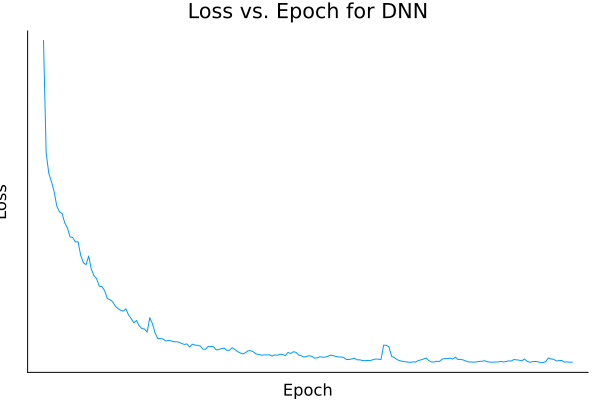

In [38]:
p1 = plot(1:epochs, total_loss_2, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch for DNN", legend=false, xticks=false, yticks=false)
display(p1)

In [39]:
preds_CNN = model(X_test)
preds_DNN = model_DNN(X_test)
;

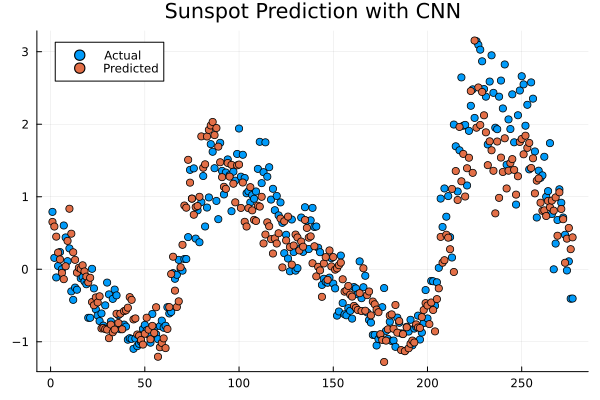

In [40]:
scatter(1:length(y_test[1, :]), y_test[1, :], label="Actual", title="Sunspot Prediction with CNN")
scatter!(1:length(preds_CNN[1, :]), preds_CNN[1, :], label="Predicted")

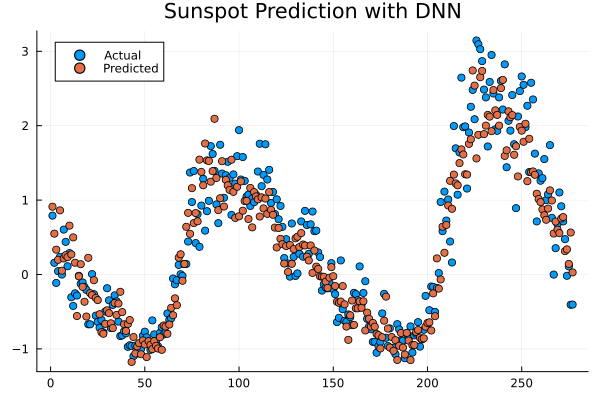

In [41]:
scatter(1:length(y_test[1, :]), y_test[1, :], label="Actual", title="Sunspot Prediction with DNN")
scatter!(1:length(vec(preds_DNN)), vec(preds_DNN), label="Predicted")